# Thermodynamic Feasibility and Sampling of Metabolite Concentrations
This notebook will demonstrate how **MASSpy** can be used to ensure thermodynamic feasibility in the metabolite concentrations of a model, and to generate samples of thermodynamically feasible metabolite concentrations for a model.

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass

import matplotlib.pyplot as plt

import numpy as np

import mass.test

from mass import MassConfiguration
from mass.thermo import ConcSolver
from mass.visualization import comparison_plot

MASSCONFIGURATION = MassConfiguration()
# Load the JSON version of the textbook model
model = mass.test.create_test_model("textbook", io="json")

Academic license - for non-commercial use only


**Note**: Throughout this notebook, the term *thermodynamic feasibility constraint* for a reaction refers to the following:

For a given reaction:
$$
\textbf{S}^T \ln{(\textbf{x})} < \ln{(\text{Keq})}\ - \epsilon\ \text{if}\ \text{v}\ > 0\\
\textbf{S}^T \ln{(\textbf{x})} > \ln{(\text{Keq})}\ + \epsilon\ \text{if}\ \text{v}\ < 0\\
$$

where 
* $\textbf{S}$ refers to the stoichiometry of the reaction
* $\textbf{x}$ refers to the vector of concentrations for the reaction metabolites
* $\text{Keq}$ refers to the equilibrium constant of the reaction
* $\text{v}$ refers to the reaction flux.
* $\epsilon$ refers to a buffer value for the constraint.

## The ConcSolver object

Upon initialization of the `ConcSolver` instance, the model becomes associated with the `ConcSolver` instance.
Metabolite concentrations and reaction equilibrium constants are added as variables to the `ConcSolver`, and thermodynamic feasibility constraints based on the reaction's flux direction and stoichiometry are created and added to the solver. Note that **all solver variables and constraints exist in logarithmic space.**

Metabolite concentrations that should be excluded from the solver can be defined using the `exclude_metabolites` argument (e.g. hydrogen and water). Reactions can also be excluded from the solver using the `exclude_reactions` argument.

Reactions that should exist at equilibrium or equilibrate very quickly should be set using the `equilibrium_reactions` argument. These reactions, such as the hemoglobin binding reactions and the adenylate kinase (ADK1) reaction, typically have a steady state flux value of 0.

In [2]:
conc_solver = ConcSolver(
    model,
    excluded_metabolites=["h_c", "h2o_c"],
    excluded_reactions=None,
    equilibrium_reactions=["HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ADK1"])
# View the model in the ConcSolver
conc_solver.model

Name,RBC_PFK
Memory address,0x01299a7250
Stoichiometric Matrix,68x76
Matrix Rank,63
Number of metabolites,68
Initial conditions defined,68/68
Number of reactions,76
Number of genes,0
Number of enzyme modules,1
Number of groups,16
Objective expression,0


The `ConcSolver` also becomes associated with the loaded model.

In [3]:
print(model.conc_solver)

<ConcSolver RBC_PFK at 0x10f5db310>


Concentrations and equilibrium constants cannot be negative numbers, therefore the bounds for each variable are set to ensure such behavior. Howevever, because $\ln(0)$ results in a domain error, the `ConcSolver` has the `zero_value_log_substitute` attribute. The value of the attribute is substituted for 0 to avoid any errors.

For example, if `zero_value_log_substitute=1e-10`, then taking the logarithm of 0 is treated as $\ln(0) \approx \ln(1*10^{-10}) = -23.026$

In [4]:
print("Substitute for ln(0): ln({0:.1e})".format(
    conc_solver.zero_value_log_substitute))

Substitute for ln(0): ln(1.0e-10)


Variables can be accessed through the `variables` attribute. The number of variables will equal the combined total of  the number of included metabolites and the number of included reactions. Specific variables can be accessed using their identifiers as a key.

In [5]:
print("Number of included metabolites: {0}".format(len(conc_solver.included_metabolites)),
      "\nNumber of included reactions: {0}".format(len(conc_solver.included_reactions)),
      "\nTotal number of variables: {0}\n".format(len(conc_solver.variables)))

# Access the glucose concentration variable
variable = conc_solver.variables["glc__D_c"]
print("The glucose concentration variable",
      "\n----------------------------------\n",
      variable)

Number of included metabolites: 66 
Number of included reactions: 48 
Total number of variables: 114

The glucose concentration variable 
----------------------------------
 -23.025850929940457 <= glc__D_c <= inf


Constraints can be accessed through the `constraints` attribute. The number of constraints will equal the number of included reactions. Just like variables, specific constraints can be accessed using reaction identifiers as a key.

In [6]:
print("Total number of constraints: {0}\n".format(len(conc_solver.constraints)))
# Access the hexokinase thermodynamic feasibility constraint
print("Thermodynamic feasibility constraint for HEX1",
      "\n-------------------------------------------\n",
      conc_solver.constraints["HEX1"])

Total number of constraints: 48

Thermodynamic feasibility constraint for HEX1 
-------------------------------------------
 HEX1: -1.0*Keq_HEX1 + 1.0*adp_c - 1.0*atp_c + 1.0*g6p_c - 1.0*glc__D_c <= 0


Currently, the constraints do not have a buffer which provides some flexibility when solving the underlying mathematical problem of the `ConcSolver`. The `constraint_buffer` attribute can be used to set the *epsilon* value of the constraint. The constraints must be reset in order for the changed buffer value to take effect.

In [7]:
conc_solver.constraint_buffer = 1e-7
conc_solver.reset_constraints()
print("Thermodynamic feasibility constraint for HEX1",
      "\n-------------------------------------------\n",
      conc_solver.constraints["HEX1"])

Thermodynamic feasibility constraint for HEX1 
-------------------------------------------
 HEX1: -1.0*Keq_HEX1 + 1.0*adp_c - 1.0*atp_c + 1.0*g6p_c - 1.0*glc__D_c <= -1e-07


Upon initialization of the `ConcSolver`, the `ConcSolver.problem_type` is considered generic and no objective is set.

In [8]:
print(conc_solver.problem_type)
print(conc_solver.objective)

generic
Maximize
0


The following sections will demonstrate different types of problems that can be solved using the `ConcSolver`.

## Solving for thermodynamically feasible concentrations
### Creating the QP problem

In order to determine thermodynamically feasible concentrations, a quadratic programming (QP) problem can be set up as follows:

Minimize
$$\ln(\bf{x}/\bf{x}_0)$$

subject to

$$
\textbf{S}^T \ln{(\textbf{x})} \lt \ln{(\text{Keq}_i)}\ - \epsilon\ \text{if}\ \text{v}_i\ \gt 0 \\
\textbf{S}^T \ln{(\textbf{x})} \gt \ln{(\text{Keq}_i)}\ + \epsilon\ \text{if}\ \text{v}_i\ \lt 0 \\
\text{Keq}_{i,\ lb} \leq \text{Keq}_i \leq \text{Keq}_{i,\ ub} \\
\text{x}_{j,\ lb} \leq \text{x}_j \leq \text{x}_{j,\ ub} \\
$$
where 
* $\textbf{S}$ refers to the stoichiometric matrix
* $\textbf{x}$ refers to the vector of metabolite concentrations
* $\textbf{x}_0$ refers to the vector of initial metabolite concentrations
* $\text{Keq}_i$ refers to the equilibrium constant of reaction $i$.
* $\text{v}_i$ refers to the flux for reaction $i$.
* $\text{x}_j$ refers to the concentration of metabolite $j$.
* $\epsilon$ refers to a buffer value for the constraint.

The first step is to set the optimization solver to one that is capable of handling quadratic objectives. Here, the [gurobi](https://www.gurobi.com/) solver will be used.

In [9]:
conc_solver.solver = conc_solver.choose_solver(qp=True)
print(repr(conc_solver.solver))

To set up the underlying mathematical problem in the `ConcSolver`, the `setup_feasible_qp_problem` method can be used. The `fixed_conc_bounds` and `fixed_Keq_bounds` arguments can be used to set the upper and lower bounds of the corresponding variables equal to one other, fixing the variable's value. In this example, the metabolite concentrations will be allowed to change, while the equilibrium constants will be fixed at their original value.

In [10]:
conc_solver.setup_feasible_qp_problem(
    fixed_Keq_bounds=conc_solver.model.reactions)

Using the `setup_feasible_qp_problem` method will also set the objective for the optimization.

In [11]:
print(conc_solver.objective_direction)
conc_solver.objective

min


After using the `setup_feasible_qp_problem` method, the `ConcSolver` is ready for optimization and the `problem_type` is changed to reflect the current problem to be solved by the solver.

In [12]:
print(conc_solver.problem_type)

feasible_qp


### The ConcSolution object
Once the `ConcSolver` is set up to solve the QP, the next step is to use the `optimize` method to solve the QP. A successful optimization will return a `ConcSolution` object. All values are transformed back into linear space upon being returned.

In [13]:
conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
glc__D_c,1.296763,0.000000
g6p_c,0.165017,0.000000
f6p_c,0.067531,0.000000
fdp_c,0.016615,0.000000
dhap_c,0.169711,0.000000
...,...,...
Keq_PFK_L,0.001100,-0.103955
Keq_PFK_T1,10.000000,-1.097455
Keq_PFK_T2,10.000000,-0.408917
Keq_PFK_T3,10.000000,0.000000


The `ConcSolution` object has several methods for viewing the results of the optimization and returning `pandas` objects containing the numerical solutions.

In [14]:
dir(conc_solution)

['Keq_reduced_costs',
 'Keqs',
 'Keqs_to_frame',
 'concentration_reduced_costs',
 'concentrations',
 'concentrations_to_frame',
 'get_primal_by_id',
 'objective_value',
 'shadow_prices',
 'status',
 'to_frame']

If the visualization feature of **MASSPy** are enabled, the predicted values can be plotted against the original model values for comparison using the `comparison_plot` method.

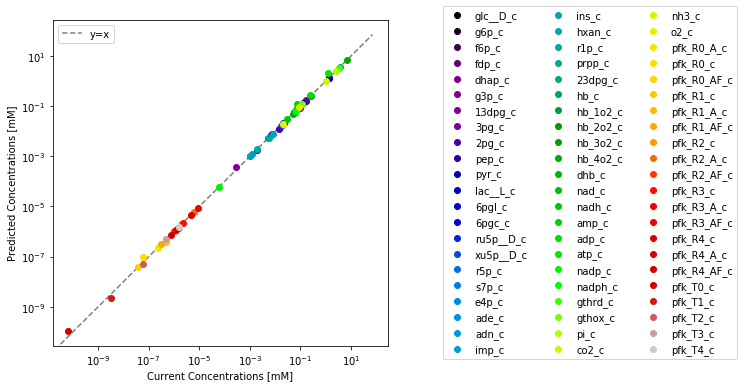

In [15]:
# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Compare values
comparison_plot(x=model, y=conc_solution, compare="concentrations",
                observable=conc_solver.included_metabolites, legend="right outside",
                xlabel="Current Concentrations [mM]", ylabel="Predicted Concentrations [mM]",
                plot_function="loglog", xy_line=True, xy_legend="best");

The model in the `ConcSolver` can be updated with the results contained within the `ConcSolution` using the `update_model_with_solution` method. Setting `inplace=True` will update the current model of the `ConcSolver`, while setting `inplace=False` will replace the model of the `ConcSolver` with a updated copy the model without modifying the original. Note that this also will remove the previous model's association with the `ConcSolver`.

In [16]:
conc_solver.update_model_with_solution(conc_solution, concentrations=True, Keqs=False,
                                       inplace=False)
print("Same model object? {0}".format(conc_solver.model == model))
print(model.conc_solver)

Same model object? False
None


## Concentration Sampling
### Basic usage

The easiest method of sampling concentrations is to use the `sample_concentrations` function in the `conc_sampling` submodule.

In [17]:
from mass.thermo.conc_sampling import sample_concentrations

To set up the `ConcSolver` for sampling, the `setup_sampling_problem` method can be used. The `conc_percent_deviation` and `Keq_percent_deviation` arguments can be used to set the variable bounds for sampling. For this example, the defined concentrations will be allowed to deviate up to %75 from their baseline value, while the defined equilibrium constants will remain fixed at their current values. 

In [18]:
conc_solver.setup_sampling_problem(
    conc_percent_deviation=0.75,
    Keq_percent_deviation=0)
print(conc_solver.problem_type)

sampling


To use the `sample_concentrations` function requires at least two arguments: a `ConcSolver` that has been set up for sampling, and the number of samples to generate.

In [19]:
samples = sample_concentrations(conc_solver, n=20)
samples.head()

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,...,pfk_R3_A_c,pfk_R3_AF_c,pfk_R4_c,pfk_R4_A_c,pfk_R4_AF_c,pfk_T0_c,pfk_T1_c,pfk_T2_c,pfk_T3_c,pfk_T4_c
0,1.838733,0.231629,0.094778,0.023103,0.175205,0.008099,0.000495,0.101416,0.014912,0.025272,...,0.000008,1.333062e-06,3.784949e-07,0.000001,2.401801e-07,3.368819e-11,7.186951e-10,1.533245e-08,1.844079e-07,4.699242e-07
1,1.676334,0.241008,0.098624,0.026317,0.192492,0.009139,0.000334,0.115339,0.016961,0.028746,...,0.000009,1.451884e-06,4.084687e-07,0.000002,2.565310e-07,3.127272e-11,6.880689e-10,1.513265e-08,1.982327e-07,5.214509e-07
2,1.514303,0.191808,0.076961,0.024225,0.177437,0.009243,0.000344,0.106695,0.015442,0.021755,...,0.000004,8.306342e-07,3.409805e-07,0.000001,2.030264e-07,2.756611e-11,6.044215e-10,1.333798e-08,1.597282e-07,4.693096e-07
3,1.644269,0.192006,0.077014,0.023385,0.171895,0.009081,0.000432,0.104493,0.015119,0.021231,...,0.000004,7.650128e-07,3.072297e-07,0.000001,2.370071e-07,3.261670e-11,7.108681e-10,1.559474e-08,1.847535e-07,4.560103e-07
4,0.778380,0.119757,0.046252,0.013005,0.108509,0.005043,0.000404,0.055853,0.006737,0.009927,...,0.000003,5.707679e-07,3.331054e-07,0.000001,3.156769e-07,4.121357e-11,7.710548e-10,1.482616e-08,1.562883e-07,4.138175e-07


By default `sample_concentrations` uses the `optgp` method <cite data-cite="optgp">
(Megchelenbrink, Huynen, and Marchiori, 2014)</cite> as it is suited for larger models and can run in parallel. By default the sampler uses the number of processes as defined in the `MassConfiguration` object. This can be changed by using the `processes` argument.

In [20]:
# print("One process:")
# %time samples = sample_concentrations(conc_solver, n=1000, processes=1)
# print("\nTwo processes:")
# %time samples = sample_concentrations(conc_solver, n=1000, processes=2)

Alternatively the Artificial Centering Hit-and-Run for sampling <cite data-cite="achr">
(Kaufman and Smith, 1998)</cite> can be utilized by setting the method to `achr`. The `achr` method does not support parallel execution but has good convergence and is almost Markovian.

In [21]:
samples = sample_concentrations(conc_solver, n=100, method="achr")

In general, setting up the sampler is expensive since initial search directions are generated by solving many linear programming problems. Thus, it is recommended to generate as many samples as possible in one go. However, this might require finer control over the sampling procedure as described in the following section.

### Advance usage
#### Sampler objects

The concentration sampling process can be controlled on a lower level by using the sampler classes directly, found in the `conc_sampling` submodule.

In [22]:
from mass.thermo.conc_sampling import ConcACHRSampler, ConcOptGPSampler

Both concentration sampler classes have standardized interfaces and take some additional arguments. 

For example, one such argument is the thinning factor, where “Thinning” means only recording samples every `x` iterations where `x` is the thinning factor. A higher thinning factors mean less correlated samples but also larger computation times.

By default the samplers use a thinning factor of 100 which creates roughly uncorrelated samples. Increasing the thinning factor leads to better mixing of samples, while lowering the thinning factor leads to more correlated samples. For example, to study convergence for a model, it may be desirable to set a thinning factor of 1 to obtain all iterates.

Samplers can also be seeded so that they produce the same results each time they are run.

In [23]:
conc_achr = ConcACHRSampler(conc_solver, thinning=1, seed=5)
samples = conc_achr.sample(10, concs=True)
# Display only the first 5 samples
samples.head(5)

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,...,pfk_R3_A_c,pfk_R3_AF_c,pfk_R4_c,pfk_R4_A_c,pfk_R4_AF_c,pfk_T0_c,pfk_T1_c,pfk_T2_c,pfk_T3_c,pfk_T4_c
0,1.633146,0.202630,0.080851,0.019395,0.145014,0.007686,0.000484,0.093033,0.013340,0.022044,...,0.000003,4.536657e-07,3.693235e-07,0.000001,2.228540e-07,3.305780e-11,6.624534e-10,1.327507e-08,1.311209e-07,3.905471e-07
1,2.252195,0.286432,0.117150,0.028806,0.043647,0.002022,0.000364,0.022234,0.003268,0.005535,...,0.000002,3.631641e-07,3.030477e-07,0.000001,1.921315e-07,2.712551e-11,5.765688e-10,1.225531e-08,1.236175e-07,3.810101e-07
2,2.264961,0.288181,0.117917,0.029007,0.045051,0.002097,0.000369,0.023146,0.003403,0.005767,...,0.000002,3.617458e-07,3.019954e-07,0.000001,1.916309e-07,2.703132e-11,5.751626e-10,1.223810e-08,1.234895e-07,3.808444e-07
3,2.260816,0.287613,0.117668,0.028942,0.044231,0.002053,0.000366,0.022618,0.003325,0.005634,...,0.000002,3.622048e-07,3.023360e-07,0.000001,1.917929e-07,2.706181e-11,5.756178e-10,1.224367e-08,1.235310e-07,3.808981e-07
4,2.267571,0.288539,0.118073,0.027143,0.043710,0.002027,0.000365,0.022300,0.003279,0.005558,...,0.000002,3.614575e-07,3.017814e-07,0.000001,1.915290e-07,2.701217e-11,5.748764e-10,1.223459e-08,1.234634e-07,3.808107e-07


The sample function also comes with a `concs` argument that controls the sample output. Setting `concs=True` will return only concentration variables, while setting `concs=False` will return the equilibrium constant variables and any additional variables as well.

In [24]:
samples = conc_achr.sample(10, concs=False)
print(samples.columns)

Index(['ade_c', 'adn_c', 'imp_c', 'prpp_c', 'nh3_c', 'glc__D_c', 'g6p_c',
       'adp_c', 'atp_c', 'Keq_HEX1',
       ...
       'pfk_T0_c', 'Keq_PFK_L', 'pfk_T1_c', 'Keq_PFK_T1', 'pfk_T2_c',
       'Keq_PFK_T2', 'pfk_T3_c', 'Keq_PFK_T3', 'pfk_T4_c', 'Keq_PFK_T4'],
      dtype='object', length=114)


The `ConcOptGPSampler` has an additional `processes` argument specifying how many processes are used to create parallel sampling chains. This should be in the order of avaialble CPU cores for maximum efficiency. As noted before class initialization can take up to a few minutes due to generation of initial search directions. Sampling on the other hand is quick.

In [25]:
conc_optgp = ConcOptGPSampler(conc_solver, processes=4, seed=5)

For the `ConcOptGPSampler`, the number of samples should be a multiple of the number of processes, otherwise it will be increased to the nearest multiple automatically.

In [26]:
samples = conc_optgp.sample(10)
print("Number of samples generated: {0}".format(len(samples)))

Number of samples generated: 12


#### Batch sampling

Sampler objects are made for generating billions of samples, however using the sample function might quickly fill up the computer RAM when working with genome-scale models. 

Here, the batch method of the sampler objects might come in handy. batch takes two arguments, the number of samples in each batch and the number of batches.

Suppose the concentration of ATP, ADP and AMP are not known. The batch sampler could be used to generate 10 batches of feasible concentrations with 100 samples each with, which could then be averaged to get the mean metabolite concentrations per batch. Finally, the mean metabolite concentrations and standard deviation could be calculated.

In [27]:
# Remove current initial conditions for example
conc_solver.model.metabolites.atp_c.ic = None
conc_solver.model.metabolites.adp_c.ic = None
conc_solver.model.metabolites.amp_c.ic = None
# Set up concentration sampling problem
conc_solver.setup_sampling_problem(
    conc_percent_deviation=0.5,
    Keq_percent_deviation=0)

# Get batch samples
conc_optgp = ConcOptGPSampler(conc_solver, processes=4, seed=5)
batch_samples = [sample for sample in conc_optgp.batch(100, 10)]

# Determine average metabolite concentrations per batch, and per 
for met in ["atp_c", "adp_c", "amp_c"]:
    met = conc_solver.model.metabolites.get_by_id(met)
    per_batch_atp_ave = [
        np.mean(sample[met.id])
        for sample in batch_samples]
    print("Ave. {2} concentration: {0:.5f} +- {1:.5f}".format(
        np.mean(per_batch_atp_ave), np.std(per_batch_atp_ave), met.id))
    met.ic = np.mean(per_batch_atp_ave)

Ave. atp_c concentration: 2.20308 +- 0.05220
Ave. adp_c concentration: 0.23834 +- 0.00494
Ave. amp_c concentration: 0.12918 +- 0.00184
